# Churn Prediction

The Beta Bank customers are leaving: little by little, chipping away every month. It’s cheaper to save the existing customers rather than to attract new ones.
We need to predict whether a customer will leave the bank soon. We have the data on clients’ past behavior and termination of contracts with the bank.
We'll build a model that tries to predict whether a customer is likely to leave.
The metric for this task is F1 score and it should be at least 0.59 .

**Project Steps** <a class="anchor" id="table_of_contents"></a>  
- [1. Data file and general info](#chapter1)  
   -  [1.1 Load dataset](#chapter1.1)  
   -  [1.2 Missing values](#chapter1.2)  
   -  [1.3 Exploratory Data Analysis](#chapter1.3)  
- [2. Building a classification model](#chapter2)   
- [3. Testing the chosen model](#chapter3)  
- [4. General conclusions](#chapter4)

## Data file and general info
***
<a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle

#ignore warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

### Load dataset
<a class="anchor" id="chapter1.1"></a>

In [2]:
#open the data file and show the first 10 rows
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Features**  
`RowNumber` — data string index  
`CustomerId` — unique customer identifier  
`Surname` — surname  
`CreditScore` — credit score  
`Geography` — country of residence  
`Gender` — gender  
`Age` — age  
`Tenure` — period of maturation for a customer’s fixed deposit (years)  
`Balance` — account balance  
`NumOfProducts` — number of banking products used by the customer  
`HasCrCard` — customer has a credit card  
`IsActiveMember` — customer’s activeness  
`EstimatedSalary` — estimated salary  

**Target**  
`Exited` — сustomer has left  

First we see that there are some coulmns that should be removed as they don't suppose to affect the target such as `RowNumber`, `CustomerId` and `Surname`.

In [3]:
#remove unnecessary columns
data.drop(['RowNumber','CustomerId','Surname'], axis=1, inplace=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
#check for duplicates
data.duplicated().sum()

0

In [5]:
#show general information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### Missing values
<a class="anchor" id="chapter1.2"></a>

We see that we don't have any duplicates but do have some missing values at the `Tenure` column, and its data type should be changed from float to int. 
We'll try to fill the missing values in the `Tenure` column.

In [6]:
#check the misiing values by columns, show in percentage
data.isna().sum()*100/len(data)

CreditScore        0.00
Geography          0.00
Gender             0.00
Age                0.00
Tenure             9.09
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.00
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

About 10% of the data for `Tenure` is missing. We'll try to figure out if the `Tenure` values related to specific feature.

In [7]:
data.corr()['Tenure']

CreditScore       -0.000062
Age               -0.013134
Tenure             1.000000
Balance           -0.007911
NumOfProducts      0.011979
HasCrCard          0.027232
IsActiveMember    -0.032178
EstimatedSalary    0.010520
Exited            -0.016761
Name: Tenure, dtype: float64

It doesn't seem that there is any correlation between the `Tenure` and the other features. As it is related to time, it might be influenced by the time the customer uses our services (the missing values might be related to new customers). As it is a numeric feature, we will take its median or mean for completing the missing values, so first we'll check the distribution.

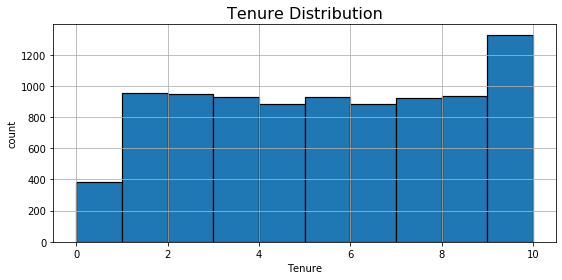

In [8]:
#show the distribution of 'Tenure' featuer
data['Tenure'].hist(edgecolor='black', linewidth=1.2, figsize=(9,4))
plt.title('Tenure Distribution', fontsize=16)
plt.xlabel('Tenure')
plt.ylabel('count');

In [9]:
data['Tenure'].median()

5.0

In [10]:
#fill the missing values with the median
data['Tenure'].fillna(data['Tenure'].median(), inplace = True)
#change the data type from float to int
data['Tenure'] = data['Tenure'].astype('int')

### Exploratory Data Analysis
<a class="anchor" id="chapter1.3"></a>

Now we'll look at the distirubtions for all the variables in the dataset.

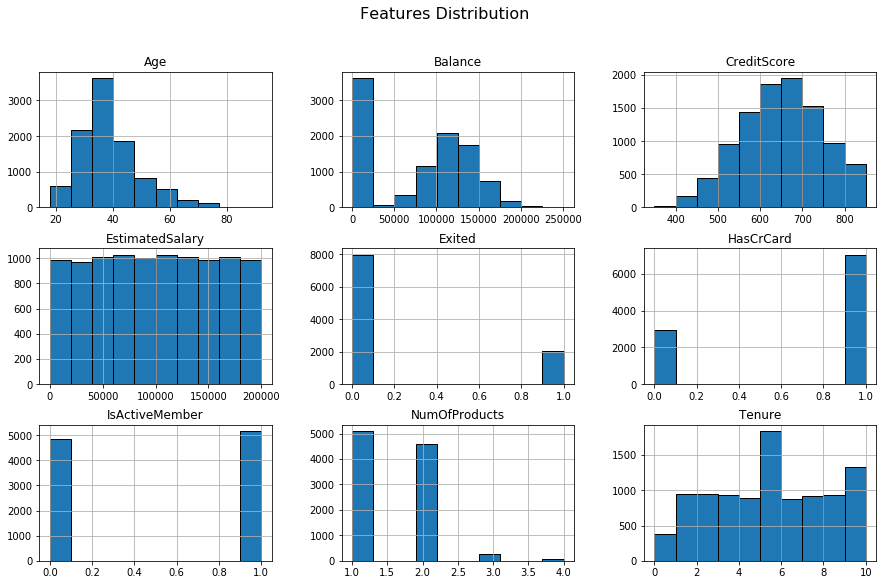

In [11]:
data.hist(edgecolor='black', figsize=(15,9))
plt.suptitle('Features Distribution', fontsize=16);

We see that there are some features that are distributed pretty much evenly (such as `EstimatedSalary` and `IsActiveMember`) but the most critical variable that is not balanced is our target variable `Exited`. There are 4 times more records for those who didn't exir our services. This imbalance might affect the result of our model. We'll deal with it later and show the difference between the results.

**Conclusions**

- We had few columns that were irrelevant for our classification task so we removed them.
- There were about 10% of missing values in the `Tenure` column which might be related to new customers. We filled it with the median value of the column and changed its type.
- The target variable is imbalanced and we need to fix it for better results.

##  Building a classification model
***
<a class="anchor" id="chapter2"></a>

**Splitting the data:**  
We will split our data into 3 parts - training set, validation set and test set, with the ratio 3:1:1.

In [12]:
target = data['Exited']
features = data.drop(['Exited'], axis=1)

In [13]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=1234
)

In [14]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=1234
)

In [15]:
print('Training set: features {}, target {}'.format(features_train.shape, target_train.shape))
print('Validation set: features {}, target {}'.format(features_valid.shape, target_valid.shape))
print('Test set: features {}, target {}'.format(features_test.shape, target_test.shape))

Training set: features (6000, 10), target (6000,)
Validation set: features (2000, 10), target (2000,)
Test set: features (2000, 10), target (2000,)


**Transforming the data:**  
We need to encode some of the categorical columns as the models can't deal with strings. Two of the categorical columns are already encoded as they are binary (`HasCrCard` and `IsActiveMember`) so we need to encode the `Geography` and `Gender` columns.
Also we need to scale the numeric columns.

In [16]:
categorical = ['Geography','Gender']
numeric = ['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'NumOfProducts', 'Tenure']

In [17]:
#apply One Hot Encoding on the categorical features
ohe = OneHotEncoder(drop='first', dtype='int8').fit(features_train[categorical])

features_train_ohe = pd.DataFrame(data=ohe.transform(features_train[categorical]).toarray(),
                                columns=ohe.get_feature_names(categorical),
                                index=features_train.index)
features_train_ohe.head()

,Geography_Germany,Geography_Spain,Gender_Male
8761,0,1,1
6016,1,0,1
1140,0,0,0
5845,1,0,1
8991,1,0,0


In [18]:
#normalize the numeric features
scaler = StandardScaler()
features_train[numeric]= scaler.fit_transform(features_train[numeric])
features_train[numeric].head()

,Age,Balance,CreditScore,EstimatedSalary,NumOfProducts,Tenure
8761,2.323416,-1.216709,-0.180546,-1.230361,0.822661,1.815334
6016,-0.097666,0.413673,2.039133,-1.002516,0.822661,0.730149
1140,-0.194510,0.328419,-0.344967,-0.042666,-0.911082,0.006692
5845,-0.581883,-0.013859,-1.249280,0.009944,-0.911082,0.006692
8991,0.289707,1.064599,-1.074583,-0.260901,-0.911082,0.006692


In [19]:
#update the features_train after OHE and scaling        
features_train = pd.concat(
    [features_train[numeric], features_train_ohe, features_train[['HasCrCard','IsActiveMember']]], axis=1
)
features_train.head()

,Age,Balance,CreditScore,EstimatedSalary,NumOfProducts,Tenure,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard,IsActiveMember
8761,2.323416,-1.216709,-0.180546,-1.230361,0.822661,1.815334,0,1,1,1,0
6016,-0.097666,0.413673,2.039133,-1.002516,0.822661,0.730149,1,0,1,0,0
1140,-0.194510,0.328419,-0.344967,-0.042666,-0.911082,0.006692,0,0,0,1,0
5845,-0.581883,-0.013859,-1.249280,0.009944,-0.911082,0.006692,1,0,1,0,1
8991,0.289707,1.064599,-1.074583,-0.260901,-0.911082,0.006692,1,0,0,1,0


In [20]:
#standardize the validation set
features_valid_ohe = pd.DataFrame(data=ohe.transform(features_valid[categorical]).toarray(),
                                columns=ohe.get_feature_names(categorical),
                                index=features_valid.index)
features_valid[numeric]= scaler.transform(features_valid[numeric])
features_valid = pd.concat(
    [features_valid[numeric], features_valid_ohe, features_valid[['HasCrCard','IsActiveMember']]], axis=1
)
features_valid.head()

,Age,Balance,CreditScore,EstimatedSalary,NumOfProducts,Tenure,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard,IsActiveMember
642,-1.162943,0.788086,-0.704637,0.168909,-0.911082,0.006692,0,0,0,1,1
9466,1.258140,-1.216709,-0.951268,0.487707,-0.911082,0.006692,0,0,1,1,0
3303,0.483393,0.922168,-0.201098,-1.163306,-0.911082,-0.716765,0,0,0,1,1
4719,-0.388196,0.750285,-0.879334,-0.610004,-0.911082,-1.440221,1,0,0,1,0
6861,0.192863,0.432359,-0.478558,0.735870,-0.911082,0.006692,0,1,1,0,0


Now both the training and validation sets are standardized and we are ready for comparing between different models.

**Selecting algorithm - imbalanced data:**  
We'll compare between three type of models:  
1) Decision Tree Classifier  
2) Random Forest Classifier  
3) Logistic Regression Classifier  

The metric we use for comparisom is the F1 score.

1) Decision Tree Classifier

In [21]:
model = DecisionTreeClassifier(random_state=1234)
param_grid_dt= {'criterion':['gini', 'entropy'], 'max_depth':[4, 8, 12, 16],
                'min_samples_split': [2, 4, 8] ,'min_samples_leaf':[1, 2, 3]}

In [22]:
#find the best hyperparameters for the classifier
dt_classifier = GridSearchCV(model, param_grid=param_grid_dt, cv=5, scoring='f1').fit(features_train, target_train)
dt_classifier.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 8}

In [23]:
#use the best hyperparameters
dt_best = DecisionTreeClassifier(random_state=1234, criterion='gini', max_depth=8, min_samples_leaf=2, min_samples_split=8)
dt_best.fit(features_train, target_train) 
print('F1 score for this model: {:.4f}'.format(f1_score(target_valid, dt_best.predict(features_valid))))
probabilities_test = dt_best.predict_proba(features_train)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this model: {:.4f}'.format(roc_auc_score(target_train, probabilities_one_test)))

F1 score for this model: 0.5331
ROC_AUC score for this model: 0.9024


2) Random Forest Classifier

In [24]:
model = RandomForestClassifier(random_state=1234)
param_grid_rf= {'criterion':['gini', 'entropy'], 'n_estimators':[20, 50, 100] ,'max_depth':[4, 8, 12, 16]}

In [25]:
#find the best hyperparameters for the classifier
rf_classifier = GridSearchCV(model, param_grid=param_grid_rf, cv=5, scoring='f1').fit(features_train, target_train)
rf_classifier.best_params_

{'criterion': 'gini', 'max_depth': 16, 'n_estimators': 100}

In [26]:
#use the best hyperparameters
rf_best = RandomForestClassifier(random_state=1234, criterion='gini', max_depth=16, n_estimators=100)
rf_best.fit(features_train, target_train) 
print('F1 score for this model: {:.4f}'.format(f1_score(target_valid, rf_best.predict(features_valid))))
probabilities_test = rf_best.predict_proba(features_train)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this model: {:.4f}'.format(roc_auc_score(target_train, probabilities_one_test)))

F1 score for this model: 0.5913
ROC_AUC score for this model: 1.0000


This score is better than the score for the Decision Tree Classifier.

3) Logistic Regression Classifier 

In [27]:
model = LogisticRegression(random_state=1234)
param_grid_lr= {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [28]:
#find the best hyperparameters for the classifier
lr_classifier = GridSearchCV(model, param_grid=param_grid_lr, cv=5, scoring='f1').fit(features_train, target_train)
lr_classifier.best_params_

{'solver': 'newton-cg'}

In [29]:
#use the best hyperparameters
lr_best = LogisticRegression(random_state=1234, solver = 'newton-cg')
lr_best.fit(features_train, target_train) 
print('F1 score for this model: {:.4f}'.format(f1_score(target_valid, lr_best.predict(features_valid))))
probabilities_test = lr_best.predict_proba(features_train)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this model: {:.4f}'.format(roc_auc_score(target_train, probabilities_one_test)))

F1 score for this model: 0.3105
ROC_AUC score for this model: 0.7702


This is the lowest score compared to the models tested.

For the imbalanced data we get the best results for the **Random Forest Classifier** that gives F1 score of 0.5913 and ROC-AUC of 1, which means the model always knows how to distinguish between the two classes and this high score related to the imbalance of the data. F1 score is only a bit higher than our target value (F1 > 0.59). Now we'll balance the traget in the training set and see how the results change.

**Selecting algorithm - balanced data:**

In [30]:
target_train.value_counts()

0    4775
1    1225
Name: Exited, dtype: int64

The records for customers that didn't leave our bank is about 4 times larger than the users who chose to leave. We have few methods to deal with this imbalance:

1) Upsampling  
2) Downsampling  
3) Class weight adjustment  

We'll define functions for the first two options and investigate the different result for each method.

In [31]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=1234)
    
    return features_upsampled, target_upsampled

In [32]:
#apply the function on the training set
features_upsampled, target_upsampled = upsample(
    features_train, target_train, 4)
display(features_upsampled.shape, target_upsampled.shape)

(9675, 11)

(9675,)

In [33]:
target_upsampled.value_counts()

1    4900
0    4775
Name: Exited, dtype: int64

Now the data balanced! We'll make another set but now, downsampled.

In [34]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1234)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1234)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=1234)
    
    return features_downsampled, target_downsampled

In [35]:
#apply the function on the training set
features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.25)
display(features_downsampled.shape, target_downsampled.shape)

(2419, 11)

(2419,)

In [36]:
target_downsampled.value_counts()

1    1225
0    1194
Name: Exited, dtype: int64

Also here the data is balnced. Now we are ready for comparing between the methods for each one of the models.

1) Desicion Tree Classifier

In [37]:
#use the class weight adjustment
dt_best = DecisionTreeClassifier(random_state=1234, criterion='gini', max_depth=8, 
                                 min_samples_leaf=2, min_samples_split=8, class_weight='balanced')
dt_best.fit(features_train, target_train) 
print('F1 score for this method: {:.4f}'.format(f1_score(target_valid, dt_best.predict(features_valid))))
probabilities_test = dt_best.predict_proba(features_train)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this method: {:.4f}'.format(roc_auc_score(target_train, probabilities_one_test)))

F1 score for this method: 0.5502
ROC_AUC score for this method: 0.9078


In [38]:
#use the upsampling method
dt_best = DecisionTreeClassifier(random_state=1234, criterion='gini', max_depth=8, 
                                 min_samples_leaf=2, min_samples_split=8)
dt_best.fit(features_upsampled, target_upsampled) 
print('F1 score for this method: {:.4f}'.format(f1_score(target_valid, dt_best.predict(features_valid))))
probabilities_test = dt_best.predict_proba(features_upsampled)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this method: {:.4f}'.format(roc_auc_score(target_upsampled, probabilities_one_test)))

F1 score for this method: 0.5564
ROC_AUC score for this method: 0.9098


In [39]:
#use the downsampling method
dt_best = DecisionTreeClassifier(random_state=1234, criterion='gini', max_depth=8, 
                                 min_samples_leaf=2, min_samples_split=8)
dt_best.fit(features_downsampled, target_downsampled) 
print('F1 score for this method: {:.4f}'.format(f1_score(target_valid, dt_best.predict(features_valid))))
probabilities_test = dt_best.predict_proba(features_downsampled)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this method: {:.4f}'.format(roc_auc_score(target_downsampled, probabilities_one_test)))

F1 score for this method: 0.5054
ROC_AUC score for this method: 0.9096


For the Decision Tree Classifier, the best results were for the upsampling method, but the score is still not high enough. The ROC_AUC score stays pretty much the same.

2) Random Forest Classifier

In [40]:
#use the class weight adjustment
rf_best = RandomForestClassifier(random_state=1234, criterion='gini', max_depth=16, n_estimators=100, class_weight='balanced')
rf_best.fit(features_train, target_train) 
print('F1 score for this method: {:.4f}'.format(f1_score(target_valid, rf_best.predict(features_valid))))
probabilities_test = rf_best.predict_proba(features_train)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this method: {:.4f}'.format(roc_auc_score(target_train, probabilities_one_test)))

F1 score for this method: 0.5551
ROC_AUC score for this method: 1.0000


In [41]:
#use the upsampling method
rf_best = RandomForestClassifier(random_state=1234, criterion='gini', max_depth=16, n_estimators=100)
rf_best.fit(features_upsampled, target_upsampled) 
print('F1 score for this method: {:.4f}'.format(f1_score(target_valid, rf_best.predict(features_valid))))
probabilities_test = rf_best.predict_proba(features_upsampled)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this method: {:.4f}'.format(roc_auc_score(target_upsampled, probabilities_one_test)))

F1 score for this method: 0.6016
ROC_AUC score for this method: 1.0000


In [42]:
#use the downsampling method
rf_best = RandomForestClassifier(random_state=1234, criterion='gini', max_depth=16, n_estimators=100)
rf_best.fit(features_downsampled, target_downsampled) 
print('F1 score for this method: {:.4f}'.format(f1_score(target_valid, rf_best.predict(features_valid))))
probabilities_test = rf_best.predict_proba(features_downsampled)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this method: {:.4f}'.format(roc_auc_score(target_downsampled, probabilities_one_test)))

F1 score for this method: 0.5871
ROC_AUC score for this method: 1.0000


Also for the Random Forest Classifier, the best results were for the upsampling method, and it is also high enough!

3) Logistic Regression Classifier

In [43]:
#use the class weight adjustment
lr_best = LogisticRegression(random_state=1234, solver = 'newton-cg', class_weight='balanced')
lr_best.fit(features_train, target_train) 
print('F1 score for this method: {:.4f}'.format(f1_score(target_valid, lr_best.predict(features_valid))))
probabilities_test = lr_best.predict_proba(features_train)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this method: {:.4f}'.format(roc_auc_score(target_train, probabilities_one_test)))

F1 score for this method: 0.4956
ROC_AUC score for this method: 0.7743


In [44]:
#use the upsampling method
lr_best = LogisticRegression(random_state=1234, solver = 'newton-cg')
lr_best.fit(features_upsampled, target_upsampled) 
print('F1 score for this method: {:.4f}'.format(f1_score(target_valid, lr_best.predict(features_valid))))
probabilities_test = lr_best.predict_proba(features_upsampled)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this method: {:.4f}'.format(roc_auc_score(target_upsampled, probabilities_one_test)))

F1 score for this method: 0.4939
ROC_AUC score for this method: 0.7743


In [45]:
#use the downsampling method
lr_best = LogisticRegression(random_state=1234, solver = 'newton-cg')
lr_best.fit(features_downsampled, target_downsampled) 
print('F1 score for this method: {:.4f}'.format(f1_score(target_valid, lr_best.predict(features_valid))))
probabilities_test = lr_best.predict_proba(features_downsampled)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for this method: {:.4f}'.format(roc_auc_score(target_downsampled, probabilities_one_test)))

F1 score for this method: 0.4939
ROC_AUC score for this method: 0.7688


There is not a great difference between the methods for the Logistic Regression Classifier and as before, we got the lowest score between the three models tested.
From what we mentioned above, we found out that the best model and method for our task is **Random Forest Classifier with upsampling method (F1=0.6016) and ROC_AUC score of 1.**

## Testing the chosen model
***
<a class="anchor" id="chapter3"></a>

Now when we have chosen the best model for our task, we'll test it with our test set. First we'll combine the training set and the validation set, as training the model on larger dataset should provide better results. The target of the training set is imblanced so we'll use the upsampling method for balancing the target variable of the training set.
Then we'll train our final model and test it.

In [46]:
#combine the training and validation sets for better results
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])
display(features_train.shape, target_train.shape)

(8000, 11)

(8000,)

In [47]:
target_train.value_counts()

0    6375
1    1625
Name: Exited, dtype: int64

As we know, our data is imbalanced, the negative class is 4 times larger than the positive class. We'll use the upsampling method for balancing it.

In [48]:
#use the upsampling method on the training set
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
display(features_upsampled.shape, target_upsampled.shape)

(12875, 11)

(12875,)

In [49]:
target_upsampled.value_counts()

1    6500
0    6375
Name: Exited, dtype: int64

Now the target variable is balanced and we can move for preprocessing the test features.

In [50]:
#standardize the test set
features_test_ohe = pd.DataFrame(data=ohe.transform(features_test[categorical]).toarray(),
                                columns=ohe.get_feature_names(categorical),
                                index=features_test.index)
features_test[numeric]= scaler.transform(features_test[numeric])
features_test = pd.concat(
    [features_test[numeric], features_test_ohe, features_test[['HasCrCard','IsActiveMember']]], axis=1
)

features_test.head()

,Age,Balance,CreditScore,EstimatedSalary,NumOfProducts,Tenure,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard,IsActiveMember
2374,-0.969256,0.916424,-0.129164,-0.054959,0.822661,-0.355036,0,1,1,1,0
1784,-0.291353,1.565884,0.066085,-0.108435,-0.911082,1.091877,0,0,1,1,1
6301,0.580237,0.344407,1.175925,0.458304,-0.911082,0.368420,1,0,0,1,0
1600,-1.066100,0.622723,-1.382872,1.362870,-0.911082,-1.078493,0,0,1,1,0
7920,-0.485040,1.040134,0.641557,-0.038999,-0.911082,0.006692,0,0,1,0,1


Now everything is ready for the final test! We'll use the same hyperparameters from the previous section. We'll also calculate the ROC-AUC score and visualize it.

In [51]:
final_model = RandomForestClassifier(random_state=1234, criterion='gini', max_depth=16, n_estimators=100)
final_model.fit(features_upsampled, target_upsampled) 
print('F1 score for the final model: {:.4f}'.format(f1_score(target_test, final_model.predict(features_test))))

F1 score for the final model: 0.6016


In [52]:
probabilities_test = final_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC score for the final model: {:.4f}'.format(roc_auc_score(target_test, probabilities_one_test)))

ROC_AUC score for the final model: 0.8483


Now we'll visualize the ROC-AUC metric.

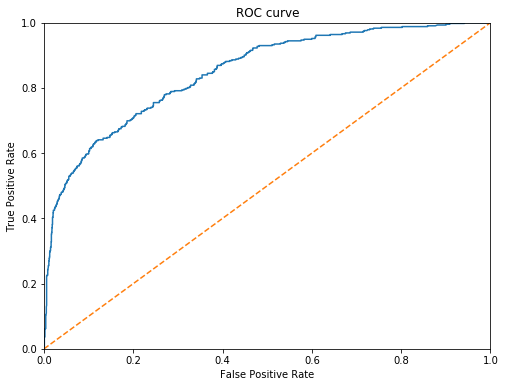

In [53]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.show()

The ROC_AUC score we get is 0.8483 which is higher than 0.5, which means the model do much better than a random model. It has a pretty good ability to distinguish between the different classes but not perfectly.

## General conclusions
***
<a class="anchor" id="chapter4"></a>

In this report, we tried to find the best model for predicting our customers churn.
We had some missing values for the `Tenure` column and the data we got had to be preprocessed for fitting to ML algorithems.
We also had data 4 times larger for the customers who stayed than for customers who left, which can cause bad results.

The data was splitted and tested on different models with different hyperparameters to achieve the best results.
We examined different data balancing techniques such as upsampling, downsampling, and class weight adjustment.

From all our test we recommend using the Random Forest Classifier ,with upsampling method for dealing with the imbalanced data, with the following hyperparameters: criterion='gini', max_depth=16, n_estimators=100.
We got F1 score of 0.6016 which exceeds the minimum threshold required for our task (F1 > 0.59).